In [1]:
import pandas as pd

In [4]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
data_dir = '../data/data_preprocessed/msp_podcast/metadata/'

In [7]:
df = pd.read_csv(f'{data_dir}data.csv')

In [8]:
df

,filename,emotion,speaker,gender
0,MSP-PODCAST_0001_0008.wav,neutral,30,male
1,MSP-PODCAST_0001_0009.wav,neutral,39,male
2,MSP-PODCAST_0001_0011.wav,neutral,39,male
3,MSP-PODCAST_0001_0013.wav,neutral,39,male
4,MSP-PODCAST_0001_0016.wav,neutral,30,male
...,...,...,...,...
73037,MSP-PODCAST_2102_0142.wav,neutral,146,female
73038,MSP-PODCAST_2102_0195.wav,neutral,1164,female
73039,MSP-PODCAST_2104_0816.wav,neutral,Unknown,unknown
73040,MSP-PODCAST_2104_2311.wav,neutral,97,male


In [9]:
audio_dir = '../data/MSP_PODCAST/Audios/'

In [10]:
df['emotion'].value_counts()

emotion
neutral         26009
happiness       14285
no_agreement    14199
surprise         4084
contempt         3644
anger            3218
sadness          2649
disgust          2593
fear             1544
other             817
Name: count, dtype: int64

In [11]:
labels = ['ang', 'neu', 'sad', 'hap']

In [12]:
df = df[df['emotion'].apply(lambda x: x[:3] in labels)]
df['emotion'].value_counts()

emotion
neutral      26009
happiness    14285
anger         3218
sadness       2649
Name: count, dtype: int64

In [13]:
df[df['speaker']=='Unknown']['emotion'].value_counts()

emotion
neutral      2774
happiness    1310
anger         371
sadness       322
Name: count, dtype: int64

In [ ]:
df_selected = df[df['speaker']=='Unknown']

In [15]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [16]:
import soundfile as sf

In [17]:
def load_audio(filename):
    waveform, sample_rate = sf.read(f'{audio_dir}{filename}') 
    return waveform

In [18]:
df_selected['audio'] = df_selected['filename'].apply(load_audio)

/tmp/ipykernel_3321598/2637325785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['audio'] = df_selected['filename'].apply(load_audio)


In [31]:
df_selected['audio'].apply(lambda x: len(x.shape)).value_counts()

audio
1    4776
2       1
Name: count, dtype: int64

In [36]:
df_selected = df_selected[df_selected['audio'].apply(lambda x: len(x.shape)==1)]

In [52]:
df_selected['audio'].apply(lambda x: len(x.shape)).value_counts()

audio
1    4776
Name: count, dtype: int64

In [37]:
data_x = df_selected['audio'].to_list()
data_y = df_selected['emotion'].to_list()

In [38]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 3820
Test: 956


In [39]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [65]:
sr = 16000

def label_to_index(word):
    return labels.index(word[:3])

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).flatten(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label_to_index(label), 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [66]:
import traceback

In [79]:
del model
gc.collect()

1899

In [80]:
from IConNet.nn.model import M18
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m18.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M18(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M18', 'description': 'FirConv sequential for speech emotion', 'fe': {'n_block': 2, 'n_channel': [128, 32], 'kernel_size': [127, 63], 'stride': [2, 8], 'window_k': [2, 9], 'mel_resolution': 4, 'residual_connection_type': 'stack', 'pooling': False, 'filter_type': 'sinc', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'seq': {'n_block': 1, 'n_channel': 48, 'out_seq_length': 8, 'use_context': False, 'bidirectional': False}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm', 'dropout': 0.15}}


M18(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2MBlocks(
    (blocks): LSTM(161, 48, batch_first=True)
    (pad_layer)

In [81]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [82]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [83]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                            | 0.003367003367003367/10 [00:00<24:47, 148.83s/it]

Train Epoch: 1 [0/3820 (0%)]	Loss: 1.672385
Mem before-during-after: 60453376 3550063616 76963328


  1%|▍                            | 0.13804713804713806/10 [00:16<21:19, 129.69s/it]

Train Epoch: 1 [640/3820 (17%)]	Loss: 0.815944
Mem before-during-after: 76886016 3565405696 76886016


  3%|▊                            | 0.27272727272727304/10 [00:31<21:01, 129.74s/it]

Train Epoch: 1 [1280/3820 (34%)]	Loss: 1.116168
Mem before-during-after: 76886016 3565405696 76886016


  4%|█▏                            | 0.4074074074074071/10 [00:47<20:55, 130.92s/it]

Train Epoch: 1 [1920/3820 (50%)]	Loss: 1.380842
Mem before-during-after: 76886016 3565405696 76886016


  5%|█▋                            | 0.5420875420875412/10 [01:03<20:17, 128.71s/it]

Train Epoch: 1 [2560/3820 (67%)]	Loss: 0.977898
Mem before-during-after: 76886016 3565405696 76886016


  7%|██                            | 0.6767676767676752/10 [01:19<19:51, 127.79s/it]

Train Epoch: 1 [3200/3820 (84%)]	Loss: 0.997926
Mem before-during-after: 76886016 3565405696 76886016


 10%|███▏                            | 0.999999999999997/10 [01:49<11:15, 75.08s/it]


Test Epoch: 1	Accuracy: 554/944 (58%)



 10%|███                            | 1.0033670033670004/10 [01:49<13:34, 90.54s/it]

Train Epoch: 2 [0/3820 (0%)]	Loss: 1.158041
Mem before-during-after: 76881920 3564357120 76361728


 11%|███▍                          | 1.1380471380471389/10 [02:05<18:53, 127.93s/it]

Train Epoch: 2 [640/3820 (17%)]	Loss: 0.980363
Mem before-during-after: 76886016 3565405696 76886016


 13%|███▊                          | 1.2727272727272774/10 [02:20<18:31, 127.41s/it]

Train Epoch: 2 [1280/3820 (34%)]	Loss: 1.378091
Mem before-during-after: 76886016 3565405696 76886016


 14%|████▏                         | 1.4074074074074159/10 [02:36<18:14, 127.41s/it]

Train Epoch: 2 [1920/3820 (50%)]	Loss: 0.678481
Mem before-during-after: 76886016 3565405696 76886016


 15%|████▋                         | 1.5420875420875544/10 [02:52<17:56, 127.22s/it]

Train Epoch: 2 [2560/3820 (67%)]	Loss: 1.559988
Mem before-during-after: 76886016 3565405696 76886016


 17%|█████▏                         | 1.676767676767693/10 [03:07<17:29, 126.11s/it]

Train Epoch: 2 [3200/3820 (84%)]	Loss: 1.165871
Mem before-during-after: 76886016 3565405696 76886016


 20%|██████▏                        | 2.0000000000000253/10 [03:37<10:27, 78.48s/it]


Test Epoch: 2	Accuracy: 552/944 (58%)



 20%|██████▏                        | 2.0033670033670288/10 [03:37<12:00, 90.15s/it]

Train Epoch: 3 [0/3820 (0%)]	Loss: 0.894637
Mem before-during-after: 76881920 3564357120 76361728


 21%|██████▍                       | 2.1380471380471673/10 [03:53<16:31, 126.07s/it]

Train Epoch: 3 [640/3820 (17%)]	Loss: 0.900855
Mem before-during-after: 76886016 3565405696 76886016


 23%|███████                        | 2.272727272727306/10 [04:09<16:17, 126.53s/it]

Train Epoch: 3 [1280/3820 (34%)]	Loss: 0.860763
Mem before-during-after: 76886016 3565405696 76886016


 24%|███████▏                      | 2.4074074074074443/10 [04:24<15:58, 126.22s/it]

Train Epoch: 3 [1920/3820 (50%)]	Loss: 1.199346
Mem before-during-after: 76886016 3565405696 76886016


 25%|███████▉                       | 2.542087542087583/10 [04:40<15:39, 125.93s/it]

Train Epoch: 3 [2560/3820 (67%)]	Loss: 0.762097
Mem before-during-after: 76886016 3565405696 76886016


 27%|████████                      | 2.6767676767677213/10 [04:55<15:19, 125.62s/it]

Train Epoch: 3 [3200/3820 (84%)]	Loss: 0.820403
Mem before-during-after: 76886016 3565405696 76886016


 30%|█████████▎                     | 3.0000000000000537/10 [05:25<08:51, 75.94s/it]


Test Epoch: 3	Accuracy: 552/944 (58%)



 30%|█████████▌                      | 3.003367003367057/10 [05:25<10:14, 87.88s/it]

Train Epoch: 4 [0/3820 (0%)]	Loss: 1.234436
Mem before-during-after: 76881920 3564357120 76361728


 31%|█████████▍                    | 3.1380471380471957/10 [05:41<14:58, 130.94s/it]

Train Epoch: 4 [640/3820 (17%)]	Loss: 0.998392
Mem before-during-after: 76886016 3565405696 76886016


 33%|██████████▏                    | 3.272727272727334/10 [05:56<14:12, 126.70s/it]

Train Epoch: 4 [1280/3820 (34%)]	Loss: 1.031874
Mem before-during-after: 76886016 3565405696 76886016


 34%|██████████▏                   | 3.4074074074074727/10 [06:12<13:51, 126.20s/it]

Train Epoch: 4 [1920/3820 (50%)]	Loss: 0.951700
Mem before-during-after: 76886016 3565405696 76886016


 35%|██████████▋                   | 3.5420875420876112/10 [06:28<13:37, 126.65s/it]

Train Epoch: 4 [2560/3820 (67%)]	Loss: 0.958456
Mem before-during-after: 76886016 3565405696 76886016


 37%|███████████                   | 3.6767676767677497/10 [06:43<13:28, 127.79s/it]

Train Epoch: 4 [3200/3820 (84%)]	Loss: 1.198278
Mem before-during-after: 76886016 3565405696 76886016


 40%|████████████▊                   | 4.000000000000082/10 [07:13<07:51, 78.53s/it]


Test Epoch: 4	Accuracy: 552/944 (58%)



 40%|████████████▊                   | 4.003367003367085/10 [07:13<09:01, 90.35s/it]

Train Epoch: 5 [0/3820 (0%)]	Loss: 0.694229
Mem before-during-after: 76881920 3564357120 76361728


 41%|████████████▊                  | 4.138047138047224/10 [07:29<12:23, 126.88s/it]

Train Epoch: 5 [640/3820 (17%)]	Loss: 0.896921
Mem before-during-after: 76886016 3565405696 76886016


 43%|█████████████▏                 | 4.272727272727362/10 [07:44<12:04, 126.58s/it]

Train Epoch: 5 [1280/3820 (34%)]	Loss: 1.221102
Mem before-during-after: 76886016 3565405696 76886016


 44%|█████████████▋                 | 4.407407407407501/10 [08:00<11:57, 128.38s/it]

Train Epoch: 5 [1920/3820 (50%)]	Loss: 1.314810
Mem before-during-after: 76886016 3565405696 76886016


 45%|██████████████                 | 4.542087542087639/10 [08:16<11:32, 126.87s/it]

Train Epoch: 5 [2560/3820 (67%)]	Loss: 1.311424
Mem before-during-after: 76886016 3565405696 76886016


 47%|██████████████▍                | 4.676767676767778/10 [08:31<11:14, 126.71s/it]

Train Epoch: 5 [3200/3820 (84%)]	Loss: 1.476983
Mem before-during-after: 76886016 3565405696 76886016


 50%|████████████████▌                | 5.00000000000011/10 [09:01<06:21, 76.35s/it]


Test Epoch: 5	Accuracy: 552/944 (58%)



 50%|████████████████                | 5.003367003367114/10 [09:02<07:24, 89.02s/it]

Train Epoch: 6 [0/3820 (0%)]	Loss: 0.934773
Mem before-during-after: 76881920 3564357120 76361728


 51%|███████████████▉               | 5.138047138047252/10 [09:17<10:14, 126.38s/it]

Train Epoch: 6 [640/3820 (17%)]	Loss: 1.174970
Mem before-during-after: 76886016 3565405696 76886016


 53%|████████████████▎              | 5.272727272727391/10 [09:33<09:59, 126.92s/it]

Train Epoch: 6 [1280/3820 (34%)]	Loss: 1.057402
Mem before-during-after: 76886016 3565405696 76886016


 54%|████████████████▊              | 5.407407407407529/10 [09:48<09:39, 126.26s/it]

Train Epoch: 6 [1920/3820 (50%)]	Loss: 1.017176
Mem before-during-after: 76886016 3565405696 76886016


 55%|█████████████████▏             | 5.542087542087668/10 [10:04<09:25, 126.83s/it]

Train Epoch: 6 [2560/3820 (67%)]	Loss: 0.954701
Mem before-during-after: 76886016 3565405696 76886016


 57%|█████████████████▌             | 5.676767676767806/10 [10:20<09:08, 126.97s/it]

Train Epoch: 6 [3200/3820 (84%)]	Loss: 1.163600
Mem before-during-after: 76886016 3565405696 76886016


 60%|██████████████████▌            | 6.0000000000001386/10 [10:49<05:07, 76.93s/it]


Test Epoch: 6	Accuracy: 552/944 (58%)



 60%|███████████████████▏            | 6.003367003367142/10 [10:50<05:55, 88.99s/it]

Train Epoch: 7 [0/3820 (0%)]	Loss: 1.111009
Mem before-during-after: 76881920 3564357120 76361728


 61%|██████████████████▍           | 6.1380471380472805/10 [11:05<08:05, 125.74s/it]

Train Epoch: 7 [640/3820 (17%)]	Loss: 0.864920
Mem before-during-after: 76886016 3565405696 76886016


 63%|███████████████████▍           | 6.272727272727419/10 [11:21<07:47, 125.52s/it]

Train Epoch: 7 [1280/3820 (34%)]	Loss: 1.059529
Mem before-during-after: 76886016 3565405696 76886016


 64%|███████████████████▏          | 6.4074074074075575/10 [11:36<07:34, 126.59s/it]

Train Epoch: 7 [1920/3820 (50%)]	Loss: 0.994943
Mem before-during-after: 76886016 3565405696 76886016


 65%|████████████████████▎          | 6.542087542087696/10 [11:52<07:16, 126.11s/it]

Train Epoch: 7 [2560/3820 (67%)]	Loss: 1.004627
Mem before-during-after: 76886016 3565405696 76886016


 67%|████████████████████▋          | 6.676767676767835/10 [12:08<07:00, 126.67s/it]

Train Epoch: 7 [3200/3820 (84%)]	Loss: 0.907624
Mem before-during-after: 76886016 3565405696 76886016


 70%|██████████████████████▍         | 7.000000000000167/10 [12:37<03:56, 78.98s/it]


Test Epoch: 7	Accuracy: 552/944 (58%)



 70%|███████████████████████          | 7.00336700336717/10 [12:38<04:32, 90.93s/it]

Train Epoch: 8 [0/3820 (0%)]	Loss: 1.155841
Mem before-during-after: 76881920 3564357120 76361728


 71%|██████████████████████▏        | 7.138047138047309/10 [12:54<06:29, 135.93s/it]

Train Epoch: 8 [640/3820 (17%)]	Loss: 0.851205
Mem before-during-after: 76886016 3565405696 76886016


 72%|██████████████████████▍        | 7.232323232323406/10 [13:05<05:25, 117.76s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f56f8194190>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f56f8194190>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 73%|██████████████████████▌        | 7.262626262626437/10 [13:09<04:57, 108.70s/it]


KeyboardInterrupt: 

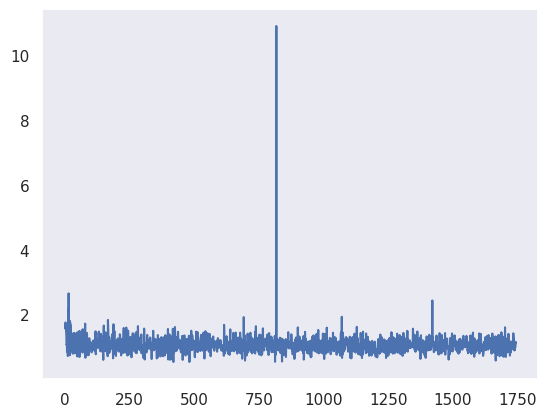

In [84]:
plt.plot(train_losses)

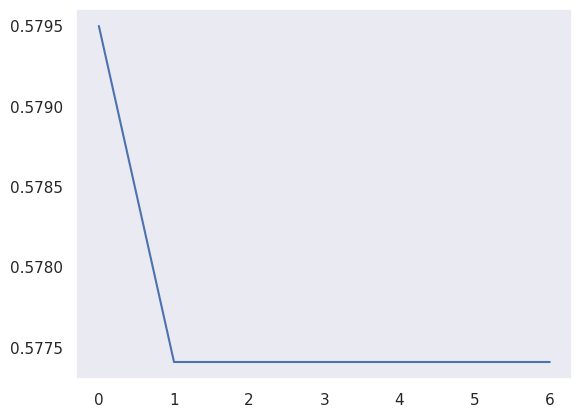

In [85]:
plt.plot(test_accuracy)

In [86]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [87]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 552/944 (0.5847)
{'acc_detail': tensor([0., 1., 0., 0.], device='cuda:0'),
 'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.5847, device='cuda:0'),
 'f1s': tensor(0.1845, device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.7380, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.5847, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0., 1., 0., 0.], device='cuda:0'),
 'rocauc': tensor([0.4993, 0.5777, 0.5926, 0.6097], device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.3419, device='cuda:0')}


tensor([[  0,  72,   0,   0],
        [  0, 552,   0,   0],
        [  0,  64,   0,   0],
        [  0, 256,   0,   0]], device='cuda:0')

In [75]:
model_path = '../models_msp4/msp4_m18_10epochs.pt' 
torch.save(model.state_dict(), model_path)

(array([ 1.,  1.,  3.,  6.,  7., 12., 12., 17., 13., 27., 19., 17., 25.,
        19., 15., 10., 16.,  5.,  4.,  8.,  3.,  4.,  2.,  1.,  2.,  1.,
         1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,
         1.]),
 array([0.00025565, 0.0003002 , 0.00034475, 0.0003893 , 0.00043385,
        0.0004784 , 0.00052295, 0.0005675 , 0.00061206, 0.00065661,
        0.00070116, 0.00074571, 0.00079026, 0.00083481, 0.00087936,
        0.00092391, 0.00096846, 0.00101301, 0.00105756, 0.00110212,
        0.00114667, 0.00119122, 0.00123577, 0.00128032, 0.00132487,
        0.00136942, 0.00141397, 0.00145852, 0.00150307, 0.00154762,
        0.00159217, 0.00163673, 0.00168128, 0.00172583, 0.00177038,
        0.00181493, 0.00185948, 0.00190403, 0.00194858, 0.00199313,
        0.00203768]),
 <BarContainer object of 40 artists>)

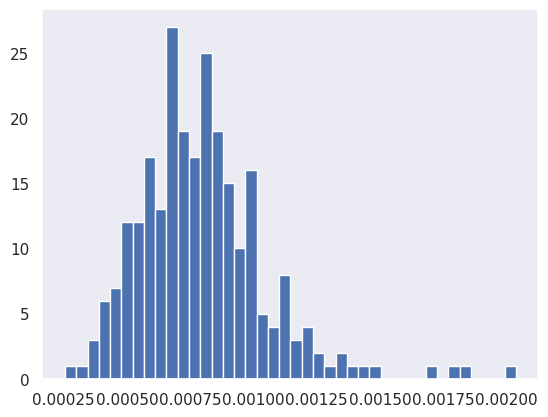

In [88]:
from IConNet.visualizer import visualize_model

layer = model.fe_blocks.blocks[0].block.layer

named_params = [p for p in layer.named_parameters()]
window_params = named_params[2][1].grad.detach().cpu().numpy()
plt.hist(window_params.flatten(), bins=40)

Time domain: Filters' shapes vary by frequency bins


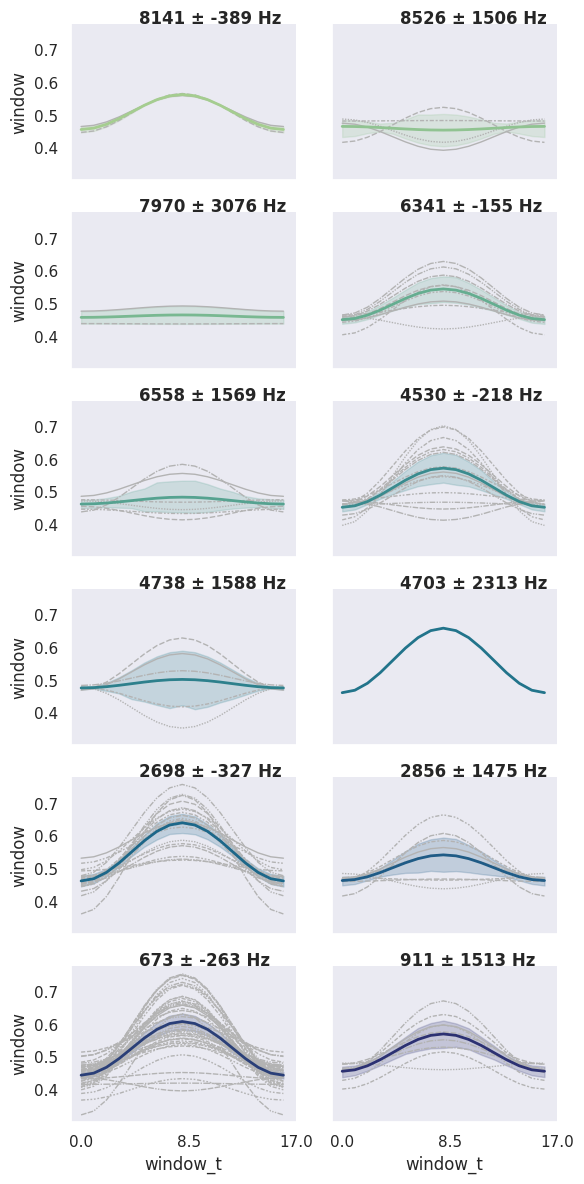

In [89]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


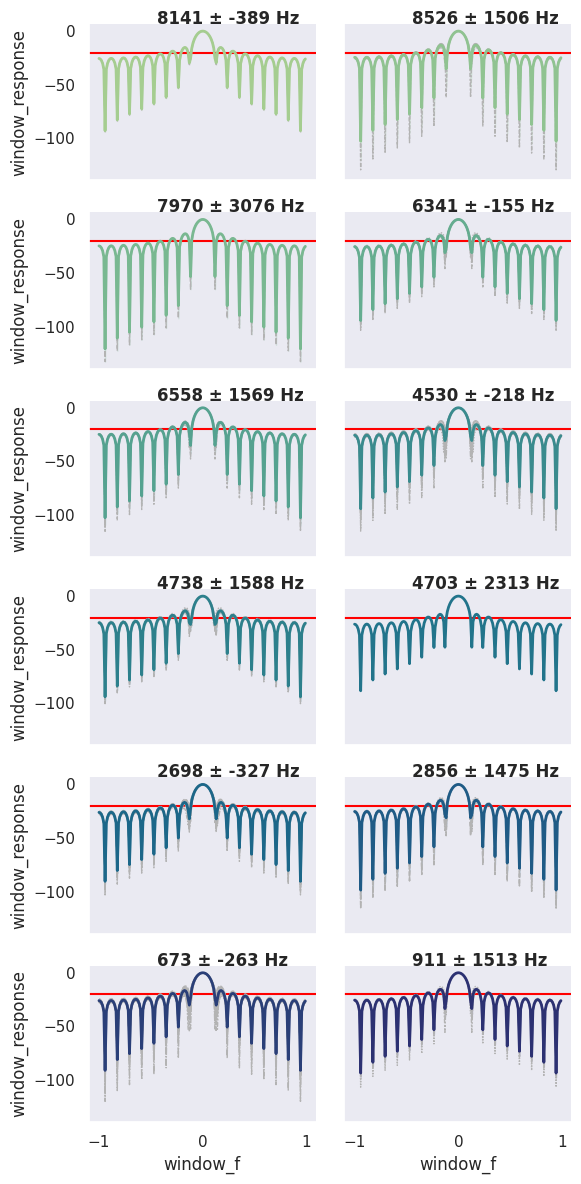

In [90]:
filtviz.visualize_filters(filter_domain='freq')

In [ ]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_msp4/msp4_m18_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
np.save('../models_msp4/msp4_m18_60epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../models_msp4/msp4_m18_60epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [ ]:
checkpoint_path = '../models_msp4/msp4_m18_60epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [ ]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 240

optimizer = optim.RAdam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()